---
title: 'Lab 6'
author: "Hunter Blinkenberg"
embed-resources: true
format: 
    html:
        toc: true
        code-fold: true
        theme: cosmo
        echo: true
---

Ethics Statement and References: This lab uses predictive modeling to design a model that predicts a baseball player's salary. Generative AI was used to help out with some of the functions that were more difficult to figure out such as how to get the ceofficients names to display along with the actual value, etc. 

In [98]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, facet_wrap, geom_point
from sklearn.model_selection import GridSearchCV

In [99]:
hits = pd.read_csv("C:/Users/hblin/OneDrive - Cal Poly/GSB 544/Week 7/Hitters.csv")

hits = hits.dropna()

# hits["Salary"] = hits["Salary"] * 1000

In [100]:
X = hits.drop("Salary", axis= 1)
y = hits["Salary"]

In [106]:
def run_regression_with_cv(X, y, regression_type):
    """
    Function to run a regression (OLS, Ridge, Lasso, ElasticNet) with cross-validation
    and return the best hyperparameter (alpha) and best cross-validated MSE score.
    
    Arguments:
    X -- Features DataFrame
    y -- Target variable
    regression_type -- Type of regression to run: 'ols', 'ridge', 'lasso', 'elasticnet'

    Returns:
    best_alpha -- Best alpha parameter found via GridSearchCV (or None for OLS)
    best_cv_mse -- Best cross-validated MSE score
    """
    # Define ColumnTransformer for preprocessing
    ct = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Initialize the regression models
    if regression_type == 'ols':
        model = LinearRegression()
        pipeline = Pipeline([("preprocessing", ct), ("regression", model)])
        # Cross-validation MSE score
        best_cv_mse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean() * -1
        pipeline.fit(X, y)  # Fit to get the coefficients

        # Extract feature names after one-hot encoding for categorical features
        categorical_feature_names = ct.transformers_[0][1].get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns)

        # Get numerical feature names
        numerical_feature_names = X.select_dtypes(include=[np.number]).columns

        # Combine all feature names (categorical and numeric)
        all_feature_names = list(categorical_feature_names) + list(numerical_feature_names)

        # Extract coefficients for the fitted model
        coefficients = pipeline.named_steps['regression'].coef_

        # Display coefficients with feature names
        print("Feature names and coefficients for OLS (Linear Regression):")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")
        
        return None, best_cv_mse  # No best alpha for OLS

    elif regression_type == 'ridge':
        model = Ridge()
        pipeline = Pipeline([("preprocessing", ct), ("ridge", model)])

        # Hyperparameter grid for Ridge
        param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}
    
    elif regression_type == 'lasso':
        model = Lasso()
        pipeline = Pipeline([("preprocessing", ct), ("lasso", model)])

        # Hyperparameter grid for Lasso
        param_grid = {"lasso__alpha": [0.001, 0.01, 0.1, 1, 10]}

    elif regression_type == 'elasticnet':
        model = ElasticNet()
        pipeline = Pipeline([("preprocessing", ct), ("elasticnet", model)])

        # Hyperparameter grid for ElasticNet
        param_grid = {"elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],
                      "elasticnet__l1_ratio": [0.1, 0.5, 0.9]}  # L1 ratio for ElasticNet

    # GridSearchCV for finding the best alpha
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    # Best hyperparameter and cross-validated MSE score
    best_alpha = grid_search.best_params_
    best_cv_mse = -grid_search.best_score_  # We negate the score to get the positive MSE
    
    # Display the results
    print(f"Best {regression_type} Alpha: {best_alpha}")
    print(f"Best Cross-Validated MSE: {best_cv_mse}")

    # Extract the coefficients and feature names for the best model
    best_pipeline = grid_search.best_estimator_

    # Get the preprocessor and model from the pipeline
    preprocessor = best_pipeline.named_steps['preprocessing']
    
    # Extract feature names for categorical columns
    cat_features = preprocessor.named_transformers_['dummify'].get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns)
    
    # Extract feature names for numerical columns
    num_features = X.select_dtypes(include=[np.number]).columns

    # Combine both categorical and numerical feature names
    all_feature_names = list(cat_features) + list(num_features)
    
    # Extract coefficients for the selected model
    coefficients = best_pipeline.named_steps[regression_type].coef_

    # Combine feature names and coefficients
    print(f"Feature names and coefficients for {regression_type}:")
    for feature, coef in zip(all_feature_names, coefficients):
        print(f"{feature}: {coef}")

    return best_alpha, best_cv_mse


# Part I: Different Model Specs

##  A. Regression without regularization 

In [102]:
best_alpha, best_cv_mse = run_regression_with_cv(X, y, regression_type='ols')
print(f"Best alpha (Ridge): {best_alpha}")
print(f"Best Cross-Validated MSE: {best_cv_mse}")



Feature names and coefficients for OLS (Linear Regression):
League_A: -31.299711517594083
League_N: 31.29971151759421
Division_E: 58.424622818437655
Division_W: -58.424622818437655
NewLeague_A: 12.381162554200026
NewLeague_N: -12.381162554200296
AtBat: -291.09455569715004
Hits: 337.8304794814834
HmRun: 37.853836764343086
Runs: -60.572478605510774
RBI: -26.99498378992079
Walks: 135.0738969513123
Years: -16.69335887510292
CAtBat: -391.038654663538
CHits: 86.68761663772092
CHmRun: -14.18172332300863
CRuns: 480.7471347707918
CRBI: 260.68988580523114
CWalks: -213.89225864291225
PutOuts: 78.76129639492689
Assists: 53.73248973474442
Errors: -22.160862174225585
Best alpha (Ridge): None
Best Cross-Validated MSE: 121136.31031816886


The most imporant coefficients are Hits, CRuns, CAtBat, CRBI, and AtBat. These suggest that hitting capabilities largely affect salary. CRuns is the biggest predictor coefficient with a predicted 480k salary increase for every career run. 

## B. Ridge regression

In [103]:
best_alpha, best_cv_mse = run_regression_with_cv(X, y, regression_type='ridge')
print(f"Best alpha (Ridge): {best_alpha}")
print(f"Best Cross-Validated MSE: {best_cv_mse}")

Best ridge Alpha: {'ridge__alpha': 1}
Best Cross-Validated MSE: 119144.43267691605
Feature names and coefficients for ridge:
League_A: -30.438855310625804
League_N: 30.438855310628888
Division_E: 60.01559492710364
Division_W: -60.015594927103336
NewLeague_A: 13.111281545686666
NewLeague_N: -13.111281545685904
AtBat: -270.68644069623673
Hits: 296.64505003257005
HmRun: 18.100591581199478
Runs: -29.339406130418972
RBI: -9.113294533329986
Walks: 124.40717273179192
Years: -38.66774782234878
CAtBat: -225.40654798156194
CHits: 126.65960654936816
CHmRun: 39.07092364167405
CRuns: 320.4121689078557
CRBI: 160.38678418275893
CWalks: -184.42361059971174
PutOuts: 78.62365619201013
Assists: 47.462597110689764
Errors: -23.724190306614684
Best alpha (Ridge): {'ridge__alpha': 1}
Best Cross-Validated MSE: 119144.43267691605


In the ridge model, CRuns is still the biggest predictor coefficient with a predicted 320k salary increase for every career run. The same variables of hitting capabilities seem to remain most important  over the career. In this model, AtBat is the next biggest predicter coefficient with a predicted -270k salary decrease with every 1 at bat. 

## C. Lasso regression

In [104]:
best_alpha, best_cv_mse = run_regression_with_cv(X, y, regression_type='lasso')
print(f"Best alpha (Ridge): {best_alpha}")
print(f"Best Cross-Validated MSE: {best_cv_mse}")

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, tole

Best lasso Alpha: {'lasso__alpha': 1}
Best Cross-Validated MSE: 119761.58740741308
Feature names and coefficients for lasso:
League_A: -35.826072111628456
League_N: 9.974641468119858e-14
Division_E: 114.41295113388867
Division_W: -2.0789294977294632e-11
NewLeague_A: 0.0
NewLeague_N: -0.0
AtBat: -282.37095717330493
Hits: 304.35950858415094
HmRun: 11.127022029363774
Runs: -24.96650711139829
RBI: -0.0
Walks: 120.69527502165931
Years: -34.94814807264341
CAtBat: -162.6397937686367
CHits: 0.0
CHmRun: 14.225993157039428
CRuns: 375.5655192079644
CRBI: 192.61089166933445
CWalks: -189.6446419428977
PutOuts: 78.76036575456914
Assists: 41.99667950395398
Errors: -18.479378396747396
Best alpha (Ridge): {'lasso__alpha': 1}
Best Cross-Validated MSE: 119761.58740741308


Similar to the last models, CRuns is the biggest predictor, with CRuns, Hits, AtBat, and CWalks are weighted the heaviest. Some coefficients have been forced to 0 as a result of the lasso regression though

## D. Elastic Net 

In [105]:
best_alpha, best_cv_mse = run_regression_with_cv(X, y, regression_type='elasticnet')
print(f"Best alpha (Ridge): {best_alpha}")
print(f"Best Cross-Validated MSE: {best_cv_mse}")

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+07, tolerance: 4.708e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e+06, tolerance: 3.606e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+07, tole

Best elasticnet Alpha: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
Best Cross-Validated MSE: 118969.49340131154
Feature names and coefficients for elasticnet:
League_A: -27.879684823579147
League_N: 27.87998426682858
Division_E: 60.67059232883931
Division_W: -60.67174944853942
NewLeague_A: 11.19158041766919
NewLeague_N: -11.19347297383407
AtBat: -231.50781166705525
Hits: 247.55614590053753
HmRun: 4.470921754490769
Runs: -5.041667988969194
RBI: 2.384347282527404
Walks: 110.80823487974342
Years: -49.54157197831513
CAtBat: -115.29371139914225
CHits: 120.01542461996134
CHmRun: 55.91505651718336
CRuns: 223.03749016380291
CRBI: 121.69342970573753
CWalks: -154.66882940112455
PutOuts: 77.91853947991538
Assists: 40.7366413934229
Errors: -24.388980915134283
Best alpha (Ridge): {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
Best Cross-Validated MSE: 118969.49340131154


Similar to other models, Hits is the biggest predictor, with CRuns, Hits, AtBat, and CWalks being weighted some of the heaviest. 

# Part II: Variable Selection

Most important numeric: CRuns 

Five most important numeric: CRuns, Hits, AtBat, Walks, and CRBI

Most important Categorical: Division 

## 1 numeric 

In [108]:
Xone = hits['CRuns']

In [ ]:

def run_regression_with_one(Xone, y, regression_type):
    """
    Function to run a regression (OLS, Ridge, Lasso, ElasticNet) with cross-validation
    and return the best hyperparameter (alpha) and best cross-validated MSE score.
    
    Arguments:
    X -- Features DataFrame
    y -- Target variable
    regression_type -- Type of regression to run: 'ols', 'ridge', 'lasso', 'elasticnet'

    Returns:
    best_alpha -- Best alpha parameter found via GridSearchCV (or None for OLS)
    best_cv_mse -- Best cross-validated MSE score
    """
    # Convert all non-numeric columns to numeric (or handle non-numeric values appropriately)
    #print("Starting preprocessing...")
    Xone = Xone.apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
    Xone.fillna(0, inplace=True)  # Optionally fill NaN values with 0 (or another strategy)

    print("Preprocessing completed.")

    # Define ColumnTransformer for preprocessing (standardizing numerical, encoding categorical)
    numerical_cols = Xone.select_dtypes(include=[np.number]).columns
    categorical_cols = Xone.select_dtypes(exclude=[np.number]).columns

    ct = ColumnTransformer(
        [
            ("standardize", StandardScaler(), numerical_cols),  # Standard scaling for numerical features
            ("encode", OneHotEncoder(), categorical_cols),  # One-hot encoding for categorical features
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Initialize the regression models
    pipeline = None  # Initialize the pipeline variable to avoid UnboundLocalError

    if regression_type == 'ols':
        print("OLS Regression selected.")
        model = LinearRegression()
        pipeline = Pipeline([("preprocessing", ct), ("regression", model)])
        
        # Cross-validation MSE score
        best_cv_mse = cross_val_score(pipeline, Xone, y, cv=5, scoring='neg_mean_squared_error').mean() * -1
        pipeline.fit(Xone, y)  # Fit to get the coefficients

        # Extract feature names
        all_feature_names = list(numerical_cols) + list(categorical_cols)

        # Extract coefficients for the fitted model
        coefficients = pipeline.named_steps['regression'].coef_

        # Display coefficients with feature names
        print("Feature names and coefficients for OLS (Linear Regression):")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")

        return None, best_cv_mse  # No best alpha for OLS

    # For Ridge, Lasso, and ElasticNet
    elif regression_type in ['ridge', 'lasso', 'elasticnet']:
        print(f"{regression_type} selected.")
        # Set model and hyperparameters based on the regression type
        if regression_type == 'ridge':
            model = Ridge()
            param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}
        elif regression_type == 'lasso':
            model = Lasso()
            param_grid = {"lasso__alpha": [0.001, 0.01, 0.1, 1, 10]}
        elif regression_type == 'elasticnet':
            model = ElasticNet()
            param_grid = {"elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],
                          "elasticnet__l1_ratio": [0.1, 0.5, 0.9]}  # L1 ratio for ElasticNet

        # Create pipeline and perform grid search
        pipeline = Pipeline([("preprocessing", ct), (regression_type, model)])  # Create pipeline here
        print("Performing GridSearchCV...")
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(Xone, y)

        # Best hyperparameter and cross-validated MSE score
        best_alpha = grid_search.best_params_
        best_cv_mse = -grid_search.best_score_  # Negating to return positive MSE
        
        # Display the results
        print(f"Best {regression_type} Alpha: {best_alpha}")
        print(f"Best Cross-Validated MSE: {best_cv_mse}")

        # Extract the coefficients and feature names for the best model
        best_pipeline = grid_search.best_estimator_
        coefficients = best_pipeline.named_steps[regression_type].coef_

        # Combine feature names (numerical + categorical)
        all_feature_names = list(numerical_cols) + list(categorical_cols)

        # Display coefficients for the selected model
        print(f"Feature names and coefficients for {regression_type}:")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")

        return best_alpha, best_cv_mse

    else:
        print(f"Invalid regression type: {regression_type}")
        return None, None


In [128]:
run_regression_with_one(Xone, y, regression_type= "ols")

Preprocessing completed.
OLS Regression selected.
Feature names and coefficients for OLS (Linear Regression):
CRuns: 253.35139209799252


(None, np.float64(143812.93591629734))

In [129]:
run_regression_with_one(Xone, y, regression_type= "ridge")

Preprocessing completed.
ridge selected.
Performing GridSearchCV...
Best ridge Alpha: {'ridge__alpha': 10}
Best Cross-Validated MSE: 143658.5173685888
Feature names and coefficients for ridge:
CRuns: 244.07112132517216


({'ridge__alpha': 10}, np.float64(143658.5173685888))

In [130]:
run_regression_with_one(Xone, y, regression_type= "lasso")

Preprocessing completed.
lasso selected.
Performing GridSearchCV...
Best lasso Alpha: {'lasso__alpha': 10}
Best Cross-Validated MSE: 143793.4491585397
Feature names and coefficients for lasso:
CRuns: 243.3513920979925


({'lasso__alpha': 10}, np.float64(143793.4491585397))

In [131]:
run_regression_with_one(Xone, y, regression_type= "elasticnet")

Preprocessing completed.
elasticnet selected.
Performing GridSearchCV...
Best elasticnet Alpha: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.5}
Best Cross-Validated MSE: 143655.07604766646
Feature names and coefficients for elasticnet:
CRuns: 241.23942104570716


({'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.5},
 np.float64(143655.07604766646))

## Five Best

In [133]:
Xfive = hits[['CRuns', 'Hits', 'AtBat', 'Walks', 'CRBI']]

In [138]:
def run_regression_with_five(Xfive, y, regression_type):
    """
    Function to run a regression (OLS, Ridge, Lasso, ElasticNet) with cross-validation
    and return the best hyperparameter (alpha) and best cross-validated MSE score.
    
    Arguments:
    X -- Features DataFrame
    y -- Target variable
    regression_type -- Type of regression to run: 'ols', 'ridge', 'lasso', 'elasticnet'

    Returns:
    best_alpha -- Best alpha parameter found via GridSearchCV (or None for OLS)
    best_cv_mse -- Best cross-validated MSE score
    """
    # Convert all non-numeric columns to numeric (or handle non-numeric values appropriately)
    #print("Starting preprocessing...")
    Xfive = Xfive.apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
    Xfive.fillna(0, inplace=True)  # Optionally fill NaN values with 0 (or another strategy)

    print("Preprocessing completed.")

    # Define ColumnTransformer for preprocessing (standardizing numerical, encoding categorical)
    numerical_cols = Xfive.select_dtypes(include=[np.number]).columns
    categorical_cols = Xfive.select_dtypes(exclude=[np.number]).columns

    ct = ColumnTransformer(
        [
            ("standardize", StandardScaler(), numerical_cols),  # Standard scaling for numerical features
            ("encode", OneHotEncoder(), categorical_cols),  # One-hot encoding for categorical features
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Initialize the regression models
    pipeline = None  # Initialize the pipeline variable to avoid UnboundLocalError

    if regression_type == 'ols':
        print("OLS Regression selected.")
        model = LinearRegression()
        pipeline = Pipeline([("preprocessing", ct), ("regression", model)])
        
        # Cross-validation MSE score
        best_cv_mse = cross_val_score(pipeline, Xfive, y, cv=5, scoring='neg_mean_squared_error').mean() * -1
        pipeline.fit(Xfive, y)  # Fit to get the coefficients

        # Extract feature names
        all_feature_names = list(numerical_cols) + list(categorical_cols)

        # Extract coefficients for the fitted model
        coefficients = pipeline.named_steps['regression'].coef_

        # Display coefficients with feature names
        print("Feature names and coefficients for OLS (Linear Regression):")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")

        return None, best_cv_mse  # No best alpha for OLS

    # For Ridge, Lasso, and ElasticNet
    elif regression_type in ['ridge', 'lasso', 'elasticnet']:
        print(f"{regression_type} selected.")
        # Set model and hyperparameters based on the regression type
        if regression_type == 'ridge':
            model = Ridge()
            param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}
        elif regression_type == 'lasso':
            model = Lasso()
            param_grid = {"lasso__alpha": [0.001, 0.01, 0.1, 1, 10]}
        elif regression_type == 'elasticnet':
            model = ElasticNet()
            param_grid = {"elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],
                          "elasticnet__l1_ratio": [0.1, 0.5, 0.9]}  # L1 ratio for ElasticNet

        # Create pipeline and perform grid search
        pipeline = Pipeline([("preprocessing", ct), (regression_type, model)])  # Create pipeline here
        print("Performing GridSearchCV...")
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(Xfive, y)

        # Best hyperparameter and cross-validated MSE score
        best_alpha = grid_search.best_params_
        best_cv_mse = -grid_search.best_score_  # Negating to return positive MSE
        
        # Display the results
        print(f"Best {regression_type} Alpha: {best_alpha}")
        print(f"Best Cross-Validated MSE: {best_cv_mse}")

        # Extract the coefficients and feature names for the best model
        best_pipeline = grid_search.best_estimator_
        coefficients = best_pipeline.named_steps[regression_type].coef_

        # Combine feature names (numerical + categorical)
        all_feature_names = list(numerical_cols) + list(categorical_cols)

        # Display coefficients for the selected model
        print(f"Feature names and coefficients for {regression_type}:")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")

        return best_alpha, best_cv_mse

    else:
        print(f"Invalid regression type: {regression_type}")
        return None, None


In [139]:
run_regression_with_five(Xfive, y, regression_type= "ols")

Preprocessing completed.
OLS Regression selected.
Feature names and coefficients for OLS (Linear Regression):
CRuns: 45.13222426606409
Hits: 368.80583284198326
AtBat: -283.49581188398906
Walks: 93.59915164465491
CRBI: 165.18729094655532


(None, np.float64(119906.79075868055))

In [140]:
run_regression_with_five(Xfive, y, regression_type= "ridge")

Preprocessing completed.
ridge selected.
Performing GridSearchCV...
Best ridge Alpha: {'ridge__alpha': 1}
Best Cross-Validated MSE: 119386.6696482726
Feature names and coefficients for ridge:
CRuns: 50.362476868900835
Hits: 336.9126865434994
AtBat: -250.39048519333912
Walks: 91.17324634130557
CRBI: 160.05870566725412


({'ridge__alpha': 1}, np.float64(119386.6696482726))

In [141]:
run_regression_with_five(Xfive, y, regression_type= "lasso")

Preprocessing completed.
lasso selected.
Performing GridSearchCV...
Best lasso Alpha: {'lasso__alpha': 1}
Best Cross-Validated MSE: 119509.30500015007
Feature names and coefficients for lasso:
CRuns: 46.1892639320874
Hits: 340.1445375678188
AtBat: -252.76090304072306
Walks: 90.35855660176503
CRBI: 163.68433349414158


({'lasso__alpha': 1}, np.float64(119509.30500015007))

In [142]:
run_regression_with_five(Xfive, y, regression_type= "elasticnet")

Preprocessing completed.
elasticnet selected.
Performing GridSearchCV...
Best elasticnet Alpha: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
Best Cross-Validated MSE: 119175.85350719497
Feature names and coefficients for elasticnet:
CRuns: 57.13906103866921
Hits: 294.6168108926609
AtBat: -206.41191006410185
Walks: 87.80892920285068
CRBI: 153.23102647057257


({'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9},
 np.float64(119175.85350719497))

## Interaction

In [ ]:
Xfive = hits[['CRuns', 'Hits', 'AtBat', 'Walks', 'CRBI', 'Division']]

In [148]:
from sklearn.preprocessing import PolynomialFeatures

def run_regression_with_five(Xfive, y, regression_type):
    """
    Function to run a regression (OLS, Ridge, Lasso, ElasticNet) with cross-validation
    and return the best hyperparameter (alpha) and best cross-validated MSE score.
    
    Arguments:
    X -- Features DataFrame
    y -- Target variable
    regression_type -- Type of regression to run: 'ols', 'ridge', 'lasso', 'elasticnet'

    Returns:
    best_alpha -- Best alpha parameter found via GridSearchCV (or None for OLS)
    best_cv_mse -- Best cross-validated MSE score
    """
    # Convert all non-numeric columns to numeric (or handle non-numeric values appropriately)
    Xfive = Xfive.apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
    Xfive.fillna(0, inplace=True)  # Optionally fill NaN values with 0 (or another strategy)

    print("Preprocessing completed.")

    # Define ColumnTransformer for preprocessing (standardizing numerical, encoding categorical)
    numerical_cols = Xfive.select_dtypes(include=[np.number]).columns
    categorical_cols = Xfive.select_dtypes(exclude=[np.number]).columns

    ct = ColumnTransformer(
        [
            ("standardize", StandardScaler(), numerical_cols),  # Standard scaling for numerical features
            ("encode", OneHotEncoder(), categorical_cols),  # One-hot encoding for categorical features
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    # Add PolynomialFeatures to create interaction terms
    interaction = PolynomialFeatures(interaction_only=False, include_bias=False)

    # Initialize the regression models
    pipeline = None  # Initialize the pipeline variable to avoid UnboundLocalError

    if regression_type == 'ols':
        print("OLS Regression selected.")
        model = LinearRegression()
        pipeline = Pipeline([
            ("preprocessing", ct), 
            ("interaction", interaction),  # Adding interaction terms
            ("regression", model)
        ])
        
        # Cross-validation MSE score
        best_cv_mse = cross_val_score(pipeline, Xfive, y, cv=5, scoring='neg_mean_squared_error').mean() * -1
        pipeline.fit(Xfive, y)  # Fit to get the coefficients

        # Extract feature names
        all_feature_names = list(numerical_cols) + list(categorical_cols)

        # Extract coefficients for the fitted model
        coefficients = pipeline.named_steps['regression'].coef_

        # Display coefficients with feature names
        print("Feature names and coefficients for OLS (Linear Regression):")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")

        return None, best_cv_mse  # No best alpha for OLS

    # For Ridge, Lasso, and ElasticNet
    elif regression_type in ['ridge', 'lasso', 'elasticnet']:
        print(f"{regression_type} selected.")
        # Set model and hyperparameters based on the regression type
        if regression_type == 'ridge':
            model = Ridge()
            param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}
        elif regression_type == 'lasso':
            model = Lasso()
            param_grid = {"lasso__alpha": [0.001, 0.01, 0.1, 1, 10]}
        elif regression_type == 'elasticnet':
            model = ElasticNet()
            param_grid = {"elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],
                          "elasticnet__l1_ratio": [0.1, 0.5, 0.9]}  # L1 ratio for ElasticNet

        # Create pipeline and perform grid search
        pipeline = Pipeline([
            ("preprocessing", ct), 
            ("interaction", interaction),  # Adding interaction terms
            (regression_type, model)
        ])  # Create pipeline here
        
        print("Performing GridSearchCV...")
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(Xfive, y)

        # Best hyperparameter and cross-validated MSE score
        best_alpha = grid_search.best_params_
        best_cv_mse = -grid_search.best_score_  # Negating to return positive MSE
        
        # Display the results
        print(f"Best {regression_type} Alpha: {best_alpha}")
        print(f"Best Cross-Validated MSE: {best_cv_mse}")

        # Extract the coefficients and feature names for the best model
        best_pipeline = grid_search.best_estimator_
        coefficients = best_pipeline.named_steps[regression_type].coef_

        # Combine feature names (numerical + categorical)
        all_feature_names = list(numerical_cols) + list(categorical_cols)

        # Display coefficients for the selected model
        print(f"Feature names and coefficients for {regression_type}:")
        for feature, coef in zip(all_feature_names, coefficients):
            print(f"{feature}: {coef}")

        return best_alpha, best_cv_mse

    else:
        print(f"Invalid regression type: {regression_type}")
        return None, None


In [149]:
run_regression_with_five(Xfive, y, regression_type= 'ols')

Preprocessing completed.
OLS Regression selected.
Feature names and coefficients for OLS (Linear Regression):
CRuns: -59.499135728742985
Hits: 67.9204947447958
AtBat: -10.29451192521862
Walks: 73.72745757858594
CRBI: 400.5530122752484


(None, np.float64(98527.61453677765))

In [150]:
run_regression_with_five(Xfive, y, regression_type= 'ridge')

Preprocessing completed.
ridge selected.
Performing GridSearchCV...
Best ridge Alpha: {'ridge__alpha': 0.001}
Best Cross-Validated MSE: 98530.92869998606
Feature names and coefficients for ridge:
CRuns: -59.44816133010122
Hits: 67.96572596155727
AtBat: -10.305761081330058
Walks: 73.7043859321674
CRBI: 400.4994619937646


({'ridge__alpha': 0.001}, np.float64(98530.92869998606))

In [146]:
run_regression_with_five(Xfive, y, regression_type= 'lasso')

Preprocessing completed.
lasso selected.
Performing GridSearchCV...


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.788e+06, tolerance: 4.708e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e+06, tolerance: 3.606e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.114e+06, tole

Best lasso Alpha: {'lasso__alpha': 0.001}
Best Cross-Validated MSE: 96634.71271346684
Feature names and coefficients for lasso:
CRuns: -42.580735785877145
Hits: 69.15167411032984
AtBat: -10.185109898279245
Walks: 73.62481386687428
CRBI: 385.4001126864816


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.764e+06, tolerance: 5.332e+03


({'lasso__alpha': 0.001}, np.float64(96634.71271346684))

In [147]:
run_regression_with_five(Xfive, y, regression_type= 'elasticnet')

Preprocessing completed.
elasticnet selected.
Performing GridSearchCV...


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.090e+06, tolerance: 4.708e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.323e+06, tolerance: 3.606e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.552e+06, tole

Best elasticnet Alpha: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}
Best Cross-Validated MSE: 97371.00054922434
Feature names and coefficients for elasticnet:
CRuns: -41.47848558574818
Hits: 70.11784955022313
AtBat: -10.541538882894747
Walks: 73.10759717641653
CRBI: 384.25094364882216


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.821e+06, tolerance: 5.332e+03


({'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9},
 np.float64(97371.00054922434))

The lasso model with the 5 variables and their interactions performed the best with an alpha of .001 and an MSE of 96634.

# Part III: Discussion 

## A. Ridge 

This relationship is somewhat inverse since Ridge regression penalizes larger coefficients more than OLS. 

## B. LASSO 

Some were the same, but most were different. This makes sense because different variables being in the model are going to cause different optimal lambdas. The presence of the variables is what is really going to make the difference between variables. 

## C. Elastic Net

Elastic net models straddle in between ridge and lasso and can be tuned to be the optimal model between the two approaches

# Part IV: Final Model

The best model was the lasso model with the 5 best variables and their interactions with the categorical variable. The lambda for this model is .001 and the best cross validated MSE is 96634. I chose to show the different MSE's that were used in the cross validation selection as it seems important to me to not only show how different variables can affect a prediction, but also how different lambdas can affect the error of a model too. 

In [156]:
# lasso model with 5 variables and their interaction
run_regression_with_five(Xfive, y, regression_type= 'lasso') 

Preprocessing completed.
lasso selected.
Performing GridSearchCV...


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.788e+06, tolerance: 4.708e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e+06, tolerance: 3.606e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.114e+06, tole

Best lasso Alpha: {'lasso__alpha': 0.001}
Best Cross-Validated MSE: 96634.71271346684
Feature names and coefficients for lasso:
CRuns: -42.580735785877145
Hits: 69.15167411032984
AtBat: -10.185109898279245
Walks: 73.62481386687428
CRBI: 385.4001126864816


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+06, tolerance: 4.558e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.764e+06, tolerance: 5.332e+03


({'lasso__alpha': 0.001}, np.float64(96634.71271346684))

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.247e+06, tolerance: 4.367e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.700e+06, tolerance: 3.931e+03
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.832e+06, tole

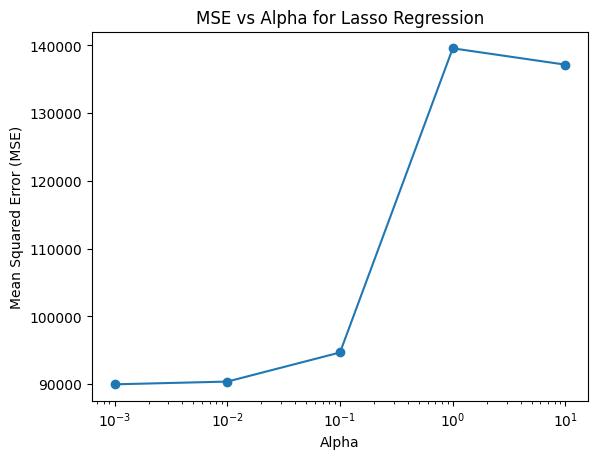

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Define the preprocessing and model setup
def create_pipeline(X):
    # Columns: numerical and categorical
    numerical_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns

    # Column transformer (for scaling numerical columns, encoding categorical ones)
    ct = ColumnTransformer(
        [
            ("standardize", StandardScaler(), numerical_cols),
            ("encode", OneHotEncoder(), categorical_cols)
        ], remainder="passthrough"
    )

    # Add polynomial features (interaction terms)
    interaction = PolynomialFeatures(interaction_only=False, include_bias=False)

    # Create a pipeline with scaling, encoding, and Lasso regression
    lasso = Lasso()
    pipeline = Pipeline([
        ("preprocessing", ct),
        ("interaction", interaction),
        ("lasso", lasso)
    ])
    
    return pipeline

# Define cross-validation
def cross_val_mse(X, y, alpha_values):
    mse_scores = []
    
    # K-Fold Cross-Validation Setup (same folds as GridSearchCV)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Ensure reproducibility
    
    # Loop over alpha values
    for alpha in alpha_values:
        model = create_pipeline(X)
        model.set_params(lasso__alpha=alpha)  # Set alpha in the Lasso model

        # Compute MSE with cross-validation
        mse = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        mse_scores.append(-mse.mean())  # Convert negative MSE to positive
        
    return mse_scores

# Define the alpha values for Lasso regularization
alpha_values = [0.001, 0.01, 0.1, 1, 10]

# Get cross-validated MSE for different alpha values
mse_scores = cross_val_mse(Xfive, y, alpha_values)

# Plot MSE vs alpha
plt.plot(alpha_values, mse_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha for Lasso Regression')
plt.show()
